In [1]:
import unipercept as up
from unimodels import multidvps

DATASET_NAME = "cityscapes-vps"

dataset = up.data.sets.get_datapipe(DATASET_NAME, split="train", all=False)
info = up.get_info(DATASET_NAME)
sample = dataset[0].unsqueeze(0)
captures = sample.captures.flatten()
print(captures)
display(up.render.plot_input_data(sample, info))

2023-12-02 14:10:16 🐛 unipercept.data.collect: Using adjacent collector (1 frames) with required sources (frozenset({'image'}),)
2023-12-02 14:10:16 🐛 unipercept.data.collect: Found 2400 sequences with 1 captures!


## Generating ground truth depth

Essentially resizes the depth map to a smaller resolution.

In [11]:
truth_generator=multidvps.modules.supervision.TruthGenerator.from_metadata(
    name=DATASET_NAME,
    ignore_val=-1,
    common_stride=4,
    min_overlap=0.7,
    gaussian_sigma=3,
)
true_depth = truth_generator.generate_depth(captures.depths, (256, 512))
display(up.render.draw_image_depth(true_depth, info))

AssertionError: Expected image with HW dimensions, got torch.Size([10, 1, 256, 512])!

## Generating scoremaps and segmentation truths

In [4]:
truth_generator=multidvps.modules.supervision.TruthGenerator.from_metadata(
    name=DATASET_NAME,
    ignore_val=-1,
    common_stride=4,
    min_overlap=0.7,
    gaussian_sigma=3,
)
hw_detections={
    "fpn.1": (64, 128),
    "fpn.2": (32, 64),
    "fpn.3": (16, 32),
    "fpn.4": (8, 16),
    "fpn.5": (4, 8),
}
true_seg = truth_generator.generate_panoptic(captures.segmentations, hw_image=captures.segmentations.shape[-2:], hw_embedding=(256, 512), hw_detections=hw_detections)

print(true_seg)

Truths(
    insmap=Tensor(shape=torch.Size([1, 256, 512]), device=cpu, dtype=torch.int64, is_shared=False),
    semmap=Tensor(shape=torch.Size([1, 256, 512]), device=cpu, dtype=torch.int64, is_shared=False),
    stuff=TensorDict(
        fields={
            fpn.1: Stuff(
                indices=Tensor(shape=torch.Size([1, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                labels=Tensor(shape=torch.Size([1, 19, 256, 512]), device=cpu, dtype=torch.float32, is_shared=False),
                masks=Tensor(shape=torch.Size([1, 19, 64, 128]), device=cpu, dtype=torch.bool, is_shared=False),
                scoremap=Tensor(shape=torch.Size([1, 19, 64, 128]), device=cpu, dtype=torch.float32, is_shared=False),
                batch_size=torch.Size([1, 19]),
                device=None,
                is_shared=False),
            fpn.2: Stuff(
                indices=Tensor(shape=torch.Size([1, 19]), device=cpu, dtype=torch.bool, is_shared=False),
                labels=Tenso

### Instance and semantic maps

The scoremap is used to train the localization head. For things, it shows the estimated keypoints as a gaussian map, 
and for stuff it is roughly equal to the segmentation map.

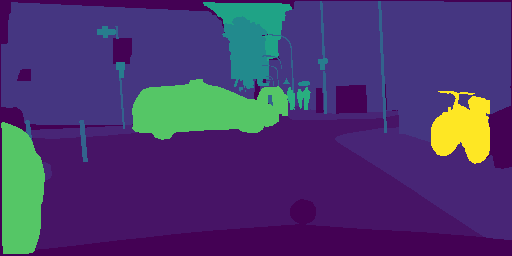

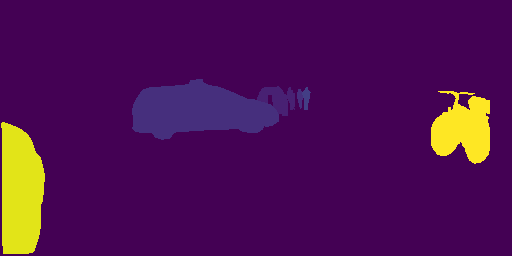

In [5]:
display(up.render.draw_map(true_seg.semmap))
display(up.render.draw_map(true_seg.insmap))

### Multi-level stuff

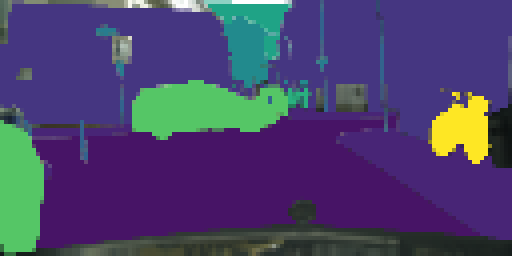

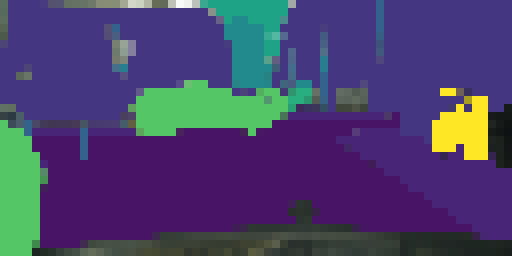

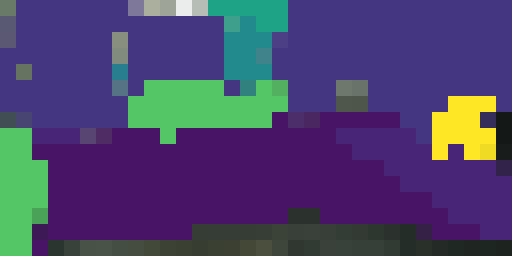

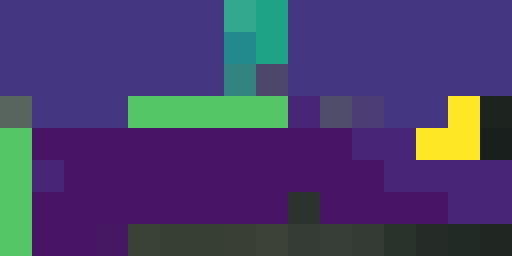

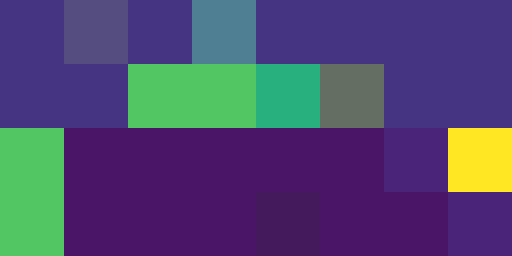

In [6]:
from PIL import Image as pil_image

for level, stuff in true_seg.stuff.items():
    display(up.render.draw_layers(stuff.scoremap, background=captures.images[0]).resize((512,256), resample=pil_image.NEAREST))

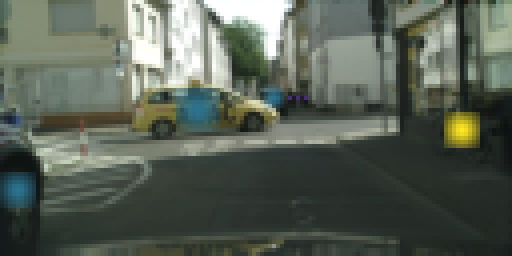

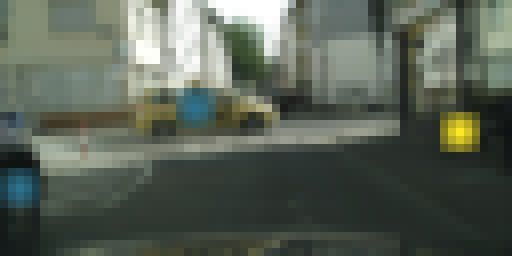

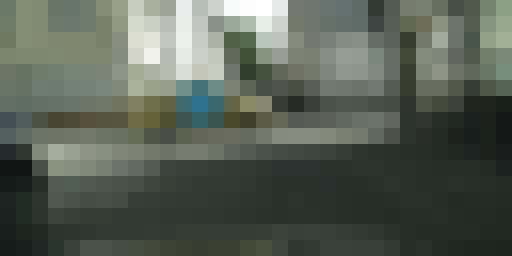

/gpfs/home3/kstolle/projects/unipercept/sources/unipercept/render/utils.py:361: RuntimeWarning: invalid value encountered in cast
  return mat.astype(np.uint8)


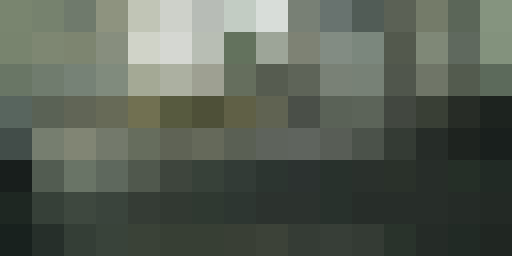

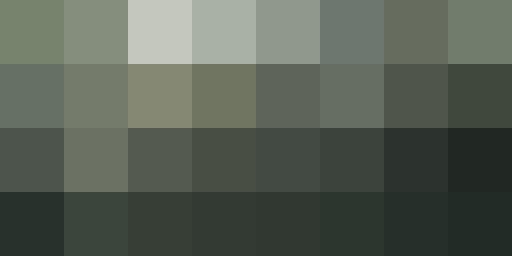

In [7]:
from PIL import Image as pil_image

for level, things in true_seg.thing.items():
    display(up.render.draw_layers(things.scoremap, background=captures.images[0]).resize((512, 256), resample=pil_image.NEAREST))

## Compiled benchmarks

In [10]:
import torch
import warnings
import random


varaints = {
    "eager": truth_generator,
    "defaults": torch.compile(truth_generator),
    "defaults+dynamic": torch.compile(truth_generator, dynamic=True),
    "defaults-dynamic": torch.compile(truth_generator, dynamic=False),
    "defaults-fullgraph": torch.compile(truth_generator, fullgraph=True),
    "max-autotune-no-cudagraphs": torch.compile(truth_generator, mode="max-autotune-no-cudagraphs"),
    "max-autotune": torch.compile(truth_generator, mode="max-autotune"),
    "onnxrt": torch.compile(truth_generator, backend="onnxrt"),
    "openxla": torch.compile(truth_generator, backend="openxla"),
    "openxla_eval": torch.compile(truth_generator, backend="openxla_eval"),
    "tvm": torch.compile(truth_generator, backend="tvm"),
    "openxla-fullgraph": torch.compile(truth_generator, backend="openxla", fullgraph=True),
}

samples = torch.stack([dataset[i] for i in random.sample(range(len(dataset)), 10)]).contiguous()
captures = samples.captures.flatten()

for name, gen in varaints.items():
    print(name)
    hw_image = captures.segmentations.shape[-2:]
    seg = captures.segmentations

    try:
        # Warmup
        gen.generate_panoptic(seg, hw_image=hw_image, hw_embedding=(256, 512), hw_detections=hw_detections)
        # Benchmark
        %timeit gen.generate_panoptic(seg, hw_image=hw_image, hw_embedding=(256, 512), hw_detections=hw_detections)
    except Exception as err:
        warnings.warn(str(err), stacklevel=3)

    # Benchmar w/ cuda
    # seg = seg.cuda()
    # try:
    #     # Warmup
    #     gen.generate_panoptic(seg, hw_image=hw_image, hw_embedding=(256, 512), hw_detections=hw_detections)
    #     # Benchmark
    #     %timeit gen.generate_panoptic(seg, hw_image=hw_image, hw_embedding=(256, 512), hw_detections=hw_detections)
    # except Exception as err:
    #     print(err)


eager
14.4 s ± 309 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
defaults
14.5 s ± 330 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
defaults+dynamic
14.6 s ± 562 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
defaults-dynamic
15.2 s ± 800 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
defaults-fullgraph
14.9 s ± 630 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
max-autotune-no-cudagraphs
14.3 s ± 288 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
max-autotune
14.9 s ± 285 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
onnxrt
15.5 s ± 2.68 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
openxla
15.7 s ± 1.15 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
openxla_eval
14.6 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
tvm
14.5 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
openxla-fullgraph
14.7 s ± 429 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
